<a href="https://colab.research.google.com/github/CerberusAtWrk/ST09/blob/main/RL_Assignment_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf 
import gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls

In [ ]:
env= gym.make("CartPole-v0")
low = env.observation_space.low
high = env.observation_space.high

In [ ]:
class critic(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    self.v = tf.keras.layers.Dense(1, activation = None)

  def call(self, input_data):
    x = self.d1(input_data)
    v = self.v(x)
    return v
    

class actor(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(128,activation='relu')
    self.a = tf.keras.layers.Dense(2,activation='softmax')

  def call(self, input_data):
    x = self.d1(input_data)
    a = self.a(x)
    return a

In [ ]:
class agent():
    def __init__(self, gamma = 0.99):
        self.gamma = gamma
        self.a_opt = tf.keras.optimizers.Adam(learning_rate=7e-3)
        self.c_opt = tf.keras.optimizers.Adam(learning_rate=7e-3)
        self.actor = actor()
        self.critic = critic()
        self.clip_pram = 0.2

          
    def act(self,state):
        prob = self.actor(np.array([state]))
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])
  


    def actor_loss(self, probs, actions, adv, old_probs, closs):
        
        probability = probs      
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability,tf.math.log(probability))))
        sur1 = []
        sur2 = []
        
        for pb, t, op in zip(probability, adv, old_probs):
                        t =  tf.constant(t)
                        op =  tf.constant(op)
                        ratio = tf.math.divide(pb,op)
                        s1 = tf.math.multiply(ratio,t)
                        s2 =  tf.math.multiply(tf.clip_by_value(ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram),t)
                        sur1.append(s1)
                        sur2.append(s2)

        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)
        
        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        return loss

    def learn(self, states, actions,  adv , old_probs, discnt_rewards):
        discnt_rewards = tf.reshape(discnt_rewards, (len(discnt_rewards),))
        adv = tf.reshape(adv, (len(adv),))

        old_p = old_probs

        old_p = tf.reshape(old_p, (len(old_p),2))
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(states, training=True)
            v =  self.critic(states,training=True)
            v = tf.reshape(v, (len(v),))
            td = tf.math.subtract(discnt_rewards, v)
            c_loss = 0.5 * kls.mean_squared_error(discnt_rewards, v)
            a_loss = self.actor_loss(p, actions, adv, old_probs, c_loss)
            
        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss

In [ ]:
def test_reward(env):
  total_reward = 0
  state = env.reset()
  done = False
  while not done:
    action = np.argmax(agentoo7.actor(np.array([state])).numpy())
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward

  return total_reward

In [ ]:

def preprocess1(states, actions, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
       delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
       g = delta + gamma * lmbda * dones[i] * g
       returns.append(g + values[i])

    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    returns = np.array(returns, dtype=np.float32)
    return states, actions, returns, adv    


tf.random.set_seed(336699)
agentoo7 = agent()
steps = 5000
ep_reward = []
total_avgr = []
target = False 
best_reward = 0
prev_reward = 0
avg_rewards_list = []


for s in range(steps):
  if target == True:
          break 
  done = False
  state = env.reset()
  all_aloss = []
  all_closs = []
  rewards = []
  states = []
  actions = []
  probs = []
  dones = []
  values = []
  print("new episode")

  for e in range(128):
   
    action = agentoo7.act(state)
    value = agentoo7.critic(np.array([state])).numpy()
    next_state, reward, done, _ = env.step(action)
    dones.append(1-done)
    rewards.append(reward)
    states.append(state)
    actions.append(action)
    prob = agentoo7.actor(np.array([state]))
    probs.append(prob[0])
    values.append(value[0][0])
    state = next_state
    if done:
      env.reset()
  
  value = agentoo7.critic(np.array([state])).numpy()
  values.append(value[0][0])
  np.reshape(probs, (len(probs),2))
  probs = np.stack(probs, axis=0)

  states, actions,returns, adv  = preprocess1(states, actions, rewards, dones, values, 1)

  for epocs in range(10):
      al,cl = agentoo7.learn(states, actions, adv, probs, returns)  

  avg_reward = np.mean([test_reward(env) for _ in range(5)])
  print(f"total test reward is {avg_reward}")
  avg_rewards_list.append(avg_reward)
  if avg_reward > best_reward:
        print('best reward=' + str(avg_reward))
        agentoo7.actor.save('model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        agentoo7.critic.save('model_critic_{}_{}'.format(s, avg_reward), save_format="tf")
        best_reward = avg_reward
  if best_reward == 200 and prev_reward == best_reward:
        target = True
  prev_reward = best_reward
  env.reset()

env.close()

new episode
total test reward is 45.6
best reward=45.6
INFO:tensorflow:Assets written to: model_actor_0_45.6/assets
INFO:tensorflow:Assets written to: model_critic_0_45.6/assets
new episode
total test reward is 98.6
best reward=98.6
INFO:tensorflow:Assets written to: model_actor_1_98.6/assets
INFO:tensorflow:Assets written to: model_critic_1_98.6/assets
new episode
total test reward is 45.4
new episode
total test reward is 80.8
new episode
total test reward is 47.4
new episode
total test reward is 63.8
new episode
total test reward is 49.6
new episode
total test reward is 80.6
new episode
total test reward is 119.8
best reward=119.8
INFO:tensorflow:Assets written to: model_actor_8_119.8/assets
INFO:tensorflow:Assets written to: model_critic_8_119.8/assets
new episode
total test reward is 112.6
new episode
total test reward is 80.8
new episode
total test reward is 68.4
new episode
total test reward is 113.8
new episode
total test reward is 198.8
best reward=198.8
INFO:tensorflow:Assets 

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

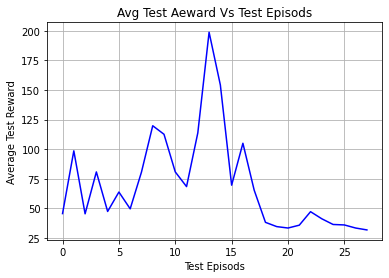

In [ ]:
ep = [i  for i in range(len(avg_rewards_list))]
plt.plot( range(len(avg_rewards_list)),avg_rewards_list,'b')
plt.title("Avg Test Aeward Vs Test Episods")
plt.xlabel("Test Episods")
plt.ylabel("Average Test Reward")
plt.grid(True)
plt.show()